# OPENAI GYM Cliff Walking / Q Learning vs n-step Q-Learning <br>
(c) Fabrice Mulotti


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from collections import deque

In [4]:
env=gym.make("CliffWalking-v0") #, desc=None, map_name="8x8", is_slippery=False)

In [5]:
num_action = env.action_space.n
num_state = env.observation_space.n

print(f"Num action={num_action}, Num State = {num_state}")

Num action=4, Num State = 48


In [6]:
def politique_egreedy(env,Q,s,epsilon):
    # en entrée : env=environnement, Q fonctions action valeur, s = état courant, epsilon= pour espilon-greedy
    r=np.random.uniform()
    if r<epsilon:
        return(env.action_space.sample())
    else:
        return(np.argmax(Q[s,]))

---
# SARSA TD-0

In [34]:
alpha=0.5   # learning rate
gamma=0.90  # part du futur
max_iter=10000# Nombre d'essai
epsilon=0.90 # part de hasard
epsilon_min=0.05
epsilon_decay=(epsilon-epsilon_min)/(50)

Q=np.zeros((env.observation_space.n,env.action_space.n))

In [35]:
# Affiche de valeurs pendant l éxecution
verbose=0

# liste des valeurs pour créer un graphique 
histoRecompense=[]
histoLongueurEpisode=[]
histo_epsilon=[]

for i in tqdm.tqdm(range(max_iter),ncols=60):
    S=env.reset()[0]

    done=False
    truncated=False
    cumulR=0 # cumul des récompenses par épisode
    cumulA=0 # cumul du nombre d'action = longueur des épisodes
    
    while not (done or truncated):

        A=politique_egreedy(env,Q,S,epsilon) # ##
        S_ , R, done, truncated, _ = env.step(A)
        A_=politique_egreedy(env,Q,S_,epsilon) # ## epsilon = 0 => pas de hasard = greedy

        cumulR+=R
        cumulA+=1
        
        if done:
           Q[S,A] = Q[S,A] +alpha*(R-Q[S,A])
           break
        
        Q[S,A] = Q[S,A] + alpha*(R+gamma*Q[S_,A_]-Q[S,A])
        # pour debug affichage
        if verbose :
            print(f"From S={S},A={A} to S_={S_},A_={A_} R={R}")
            if done:
                print("----------------------------------------------------")



        # Votre code : transition etat et action S=... A=...
        S=S_
        # ## A=A_

    histo_epsilon.append(epsilon)
    epsilon=max(epsilon_min,epsilon-epsilon_decay)
    histoRecompense.append(cumulR)
    histoLongueurEpisode.append(cumulA)


100%|███████████████| 10000/10000 [00:03<00:00, 2582.80it/s]


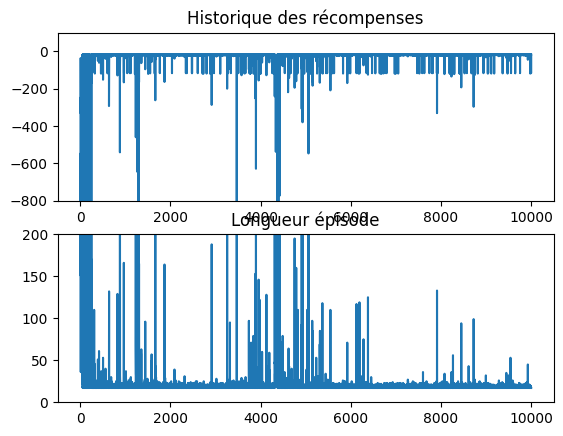

In [36]:
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
ax1.set_title("Historique des récompenses")
ax1.plot(histoRecompense)
ax1.set_ylim(-800,100)

ax2.set_title("Longueur épisode")
ax2.plot(histoLongueurEpisode)
ax2.set_ylim(0,200)
plt.show()

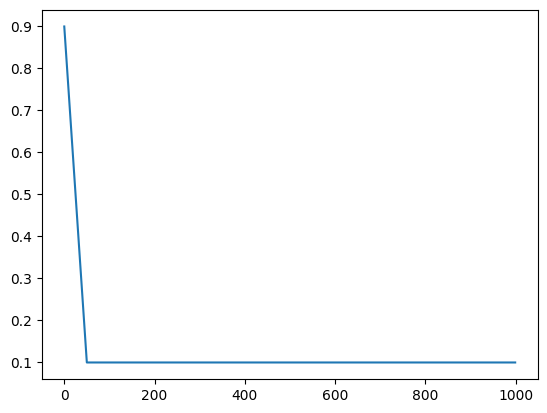

In [24]:
plt.figure()
plt.plot(histo_epsilon)
plt.show()


----
# SARSA n-step 

![nstep](static/n-step.png)

In [50]:
alpha=0.5   # learning rate
gamma=0.95  # part du futur
max_iter=5000# Nombre d'essai
epsilon=0.90 # part de hasard
epsilon_min=0.10
epsilon_decay=(epsilon-epsilon_min)/(max_iter/4)

n_step=5

Q=np.zeros((env.observation_space.n,env.action_space.n))

In [51]:
# Affiche de valeurs pendant l éxecution
verbose=0

# liste des valeurs pour créer un graphique 
histoRecompense=[]
histoLongueurEpisode=[]
buffer_size=1000

for i in tqdm.tqdm(range(max_iter),ncols=60):
    
    state_buffer=deque(maxlen=buffer_size)
    action_buffer=deque(maxlen=buffer_size)
    reward_buffer=deque(maxlen=buffer_size)
    
    state_buffer.append(env.reset()[0])
    action_buffer.append(politique_egreedy(env,Q,state_buffer[0],epsilon))
    
    done=False
    A = action_buffer[0]
    cumulR=0
    while len(state_buffer) > 0 :
        if not done:
            S_, R, done_ ,truncated , _ = env.step(A)
            if truncated:
                done_ = True
            reward_buffer.append(R)
            cumulR += R
            if not done_:
                A_=politique_egreedy(env,Q,S_,epsilon)
                state_buffer.append(S_)
                action_buffer.append(A_)
                
        if len(reward_buffer)-1 == n_step or done:
            G=np.sum([reward_buffer[i]*(gamma**i) for i in range(len(reward_buffer))])
            if not done:
                G += (gamma**n_step) * Q[S_,A_]
                
            s0=state_buffer[0]
            a0=action_buffer[0]
            Q0=Q[s0,a0]
            Q[ s0,a0 ] = Q0 + alpha * (G - Q0)
                
            del state_buffer[0]
            del action_buffer[0]
            del reward_buffer[0]
            # print(len(reward_buffer),done_)
        
        S=S_
        A=A_
        done=done_
        # print(cumulR)
        

    epsilon=max(epsilon_min,epsilon-epsilon_decay)
    histoRecompense.append(cumulR)
    # histoLongueurEpisode.append(cumulA)

100%|██████████████████| 5000/5000 [00:11<00:00, 447.53it/s]


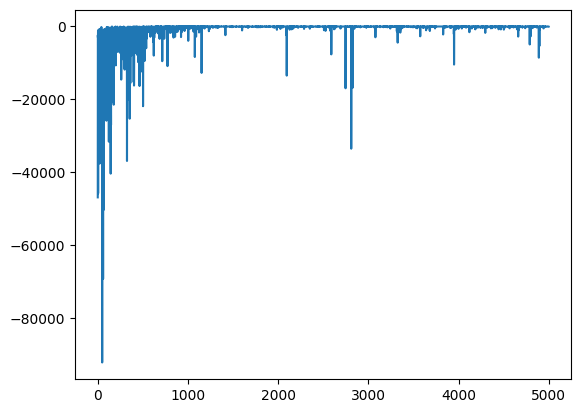

In [52]:
plt.figure()
plt.plot(histoRecompense)
plt.show()
